# Data evaluation hands-on

This iPython notebook is designed to fully evaluate the data of experiment [ILL-DATA.TEST-2385](https://doi.ill.fr/10.5291/ILL-DATA.TEST-2385) and generate all figures which are needed for our manuscript..

The work is done in 2 steps:

1. Downloading the data (optional)
2. Evaluating the data


## Downloading the data

It is recommended to download the data from [its source][1].

It is not possible to download the data without ILL credentials. An automatic script, using `requests` and the `BeutifulSoup4` packages, which create a HTTPS session to the data.ill.fr server, is used for this. For this ILL credentials are needed. Currently, it is possible to get the ILL credentials by registering at [The ILL user club][2]. After entering the correct credentials, the script will download all datafiles from the raw data directory of the experiment.

This approach will stop working if:
- ILL changes the structure of its login page
- ILL changes how to download the data
- ILL changes how to register at the User Club

If the automatic data download does not work, it is possible to follow the [originally published doi][1] and download the data manually. It can then be uploaded manually to the rawdata folder.

In case neither of these options work the original data are provided in this repository. The data are already in the rawdata directory and the next step can be skipped. 
Otherwise, SHIFT + ENTER are used to execute the cell. ILL USER CLUB username and password need to be entered here. An empty username will result in skipping the next step.

[1]: https://doi.ill.fr/10.5291/ILL-DATA.TEST-2385
[2]: https://userclub.ill.eu/

In [19]:
# import libraries i will need
# for downloading files from itnernet
import requests
# for parsing html data
from bs4 import BeautifulSoup
# for creating folder
import os
# for entering password
import getpass

user = input("Enter username for data.ill.fr: ")
pw = getpass.getpass("Enter password for data.ill.fr: ")

if user == '':
    raise ValueError('You have not entered any ILL username. The downloading of the data will be skipped.')

payload = {
    'username': user,
    'password': pw
}
data_url = 'https://data.ill.eu/proposal/getfile?download=1&file=171/in3/internalUse/rawdata/%06d'

# 171/in3/internalUse/rawdata/ 

if not os.path.exists('rawdata'):
    os.mkdir('rawdata')

with requests.Session() as sess:
    res = sess.get('http://data.ill.fr/')  
    signin = BeautifulSoup(res._content, 'html.parser')
    url = signin.find('form', id='kc-form-login')['action']
    res = sess.post(url, data=payload)
    print('Downloading datafiles: ', end='')
    for numor in range(102942, 102972): # 102942 - 102971
        r = sess.get(data_url % numor, allow_redirects=True)
        if 'text/plain' in r.headers['Content-Type']:
            open('rawdata/%06d' % numor, 'wb').write(r.content)
            print(f'{numor} ', end='')
        else:
            raise ValueError('The script is not able to download datafiles, either you have provided wrong ILL credentials or the format of the ILL webportal is changed.')

Enter username for data.ill.fr:  ankitlabh
Enter password for data.ill.fr:  ········


## Evaluating the data

Here datafile `102969`, which we are evaluating (the previous datafiles are sample alignment scans) is plotted.

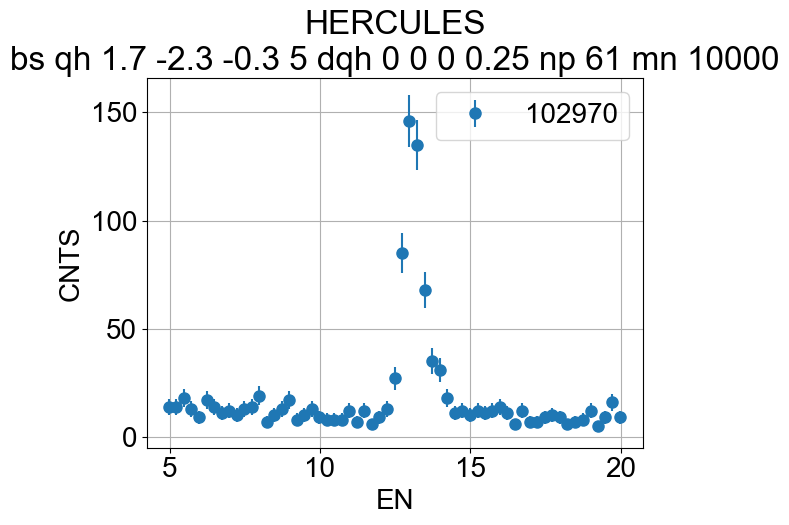

In [32]:
from ufit.lab import *
%matplotlib inline

# set a template, so that data can be referenced by number only
set_datatemplate('rawdata/%06d')
# read one dataset from a file, with given X and Y columns
data = read_data(102970, 'EN', 'CNTS') # EN is energy scan; QL is Q scan in L direction

data.plot()
show()

### Fitting the data

A simple model with two Gaussians is used to fit the data. The center of the second Gaussian is at the negative rlu value of the first.

Fit results for 102970
--------------------------------------------------------------------------------
bkgd            =     9.9578 +/-    0.46624
p1_pos          =     13.099 +/-   0.019444
p1_ampl         =     136.26 +/-     9.5082
p1_fwhm         =     0.7655 +/-   0.039408
chi^2/NDF       =      1.171


C:\programs\anaconda\lib\site-packages\ufit\plotting.py:175: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  self.axes.plot(xxp, yy + offset, kw.pop('fmt', 'g'),


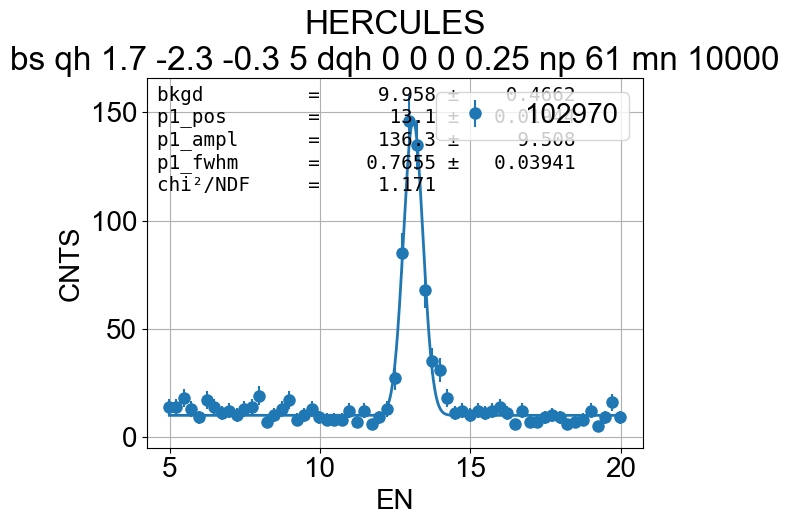

In [47]:
# create a model of a simple Gaussian peak with given initial guess
# model = Background() + Gauss('p1', pos=0.1, ampl=100, fwhm=0.1) + Gauss('p2', pos='-p1_pos', ampl=100, fwhm=0.1)
model = Background() + Gauss('p1', pos=13, ampl=100, fwhm=2)

# fit the model, then print and plot the result
result = model.fit(data)
result.printout()
result.plot()
show()

### Nicer plot

Now the fitted data is plotted, in a way suitable for publication. The file is then saved as an `eps` file.

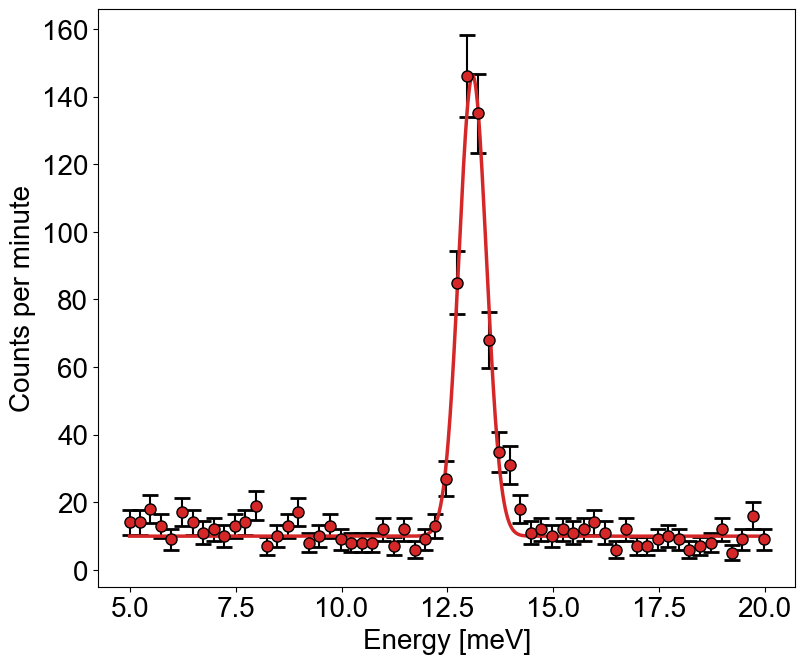

In [48]:
rcParams.update({'font.size': 20})
fig = figure(figsize=(9.0, 7.5))
data.plot(color="C3", mec="k", ms=8, capsize=6, ecolor="k", capthick=2)
model.plot(data, color="C3", lw=2.5)
title("")
legend().set_visible(False)
#xlabel("(-2+$\delta$ 2+$\delta$ 0+$\delta$) (rlu)", fontsize=20)
xlabel("Energy [meV]", fontsize = 20)
ylabel("Counts per minute", fontsize=20)

grid(False)
savefig("energy-scan.eps", bbox_inches='tight')
show()

### Conversion of results

Next, the energy units used here (meV) are converted to the units used in [Aouissi et al.](https://doi.org/10.1103/PhysRevB.74.054302) (cm$^{-1}$).

In [59]:
energy = result.paramvalues['p1_pos']
print(energy) # energy in meV
energy *= 8.065610 # conversion of meV to cm-1 ; https://sherwingroup.itst.ucsb.edu/internal/unit-conversion/
print(energy) # energy in cm^-1

energyerror = result.paramerrors['p1_pos']
print(energyerror) # energy in meV
energyerror *= 8.065610 # conversion of meV to cm-1 ; https://sherwingroup.itst.ucsb.edu/internal/unit-conversion/
print(energyerror) # energy in cm^-1

13.099208459833076
105.65310674571424
0.019444188306730188
0.15682923964864606


### Plot the results

The last cell is used to plot the extracted excitation as a function of its position in the Brillouin zone. As a background of the plot Fig. 3 from [Aouissi et al.](https://doi.org/10.1103/PhysRevB.74.054302) was used as a comparison.

In [57]:
abs(result.data.meta['QL'])

0.29934262295081965

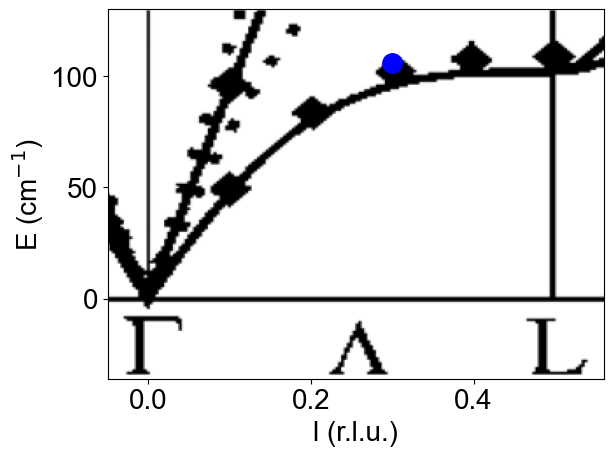

In [67]:
img = imread("phonon.png")
fig, ax = subplots()
#errorbar([result.paramvalues['p1_pos']], [energy], xerr=result.paramerrors['p1_pos'], fmt='bo', ms = 14)
errorbar([abs(result.data.meta['QL'])], [energy], yerr=[energyerror], fmt='bo', ms = 14)

ax.imshow(img, extent=[-0.05, 1.12/2, -36, 130], aspect='auto')
xlabel("l (r.l.u.)")
ylabel("E (cm$^{-1}$)")
savefig("dispersion.eps", bbox_inches='tight')
show()